In [74]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Dataset

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2024-05-28 18:58:45--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2024-05-28 18:58:45 (10,2 MB/s) - ‘housing.csv’ saved [1423529/1423529]



## EDA

In [3]:
df = pd.read_csv("housing.csv")

### Look at the median_house_value variable. 

/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


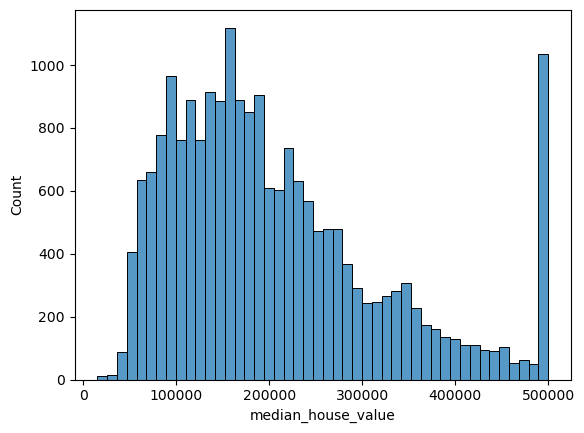

In [13]:
sns.histplot(df["median_house_value"]);

### Does it have a long tail? No

In [91]:
df_work = df.drop(columns='ocean_proximity')

## Question 1
### Find a feature with missing values. How many missing values does it have?

In [92]:
df_work.isna().sum()[df_work.isna().sum() > 0]

total_bedrooms    207
dtype: int64

## Question 2
### What's the median (50% percentile) for variable 'population'?

In [93]:
df_work.population.describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

## Split the data
1. Shuffle the initial dataset, use seed 42.
2. Split your data in train/val/test sets, with 60%/20%/20% distribution.
3. Make sure that the target value ('median_house_value') is not in your dataframe.
4. Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [121]:
n = len(df_work)
nval = int(0.2 * n)
ntest = int(0.2 * n)
ntrain = n - (nval + ntest)
assert (nval+ ntest +ntrain) == n

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df_work.iloc[idx]

df_train = df_shuffled.iloc[:ntrain]
df_val = df_shuffled.iloc[ntrain:ntrain+nval]
df_test = df_shuffled.iloc[ntrain+nval:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

In [122]:
del df_val['median_house_value']
del df_test['median_house_value']
del df_train['median_house_value']

## Question 3
1. We need to deal with missing values for the column from Q1.
2. We have two options: fill it with 0 or with the mean of this variable.
3. Try both options. For each, train a linear regression model without regularization using the code from the lessons.
4. For computing the mean, use the training only!
5. Use the validation dataset to evaluate the models and compare the RMSE of each option.
6. Round the RMSE scores to 2 decimal digits using round(score, 2)

In [123]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


In [124]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

#### Option 1

In [125]:
# Training
df_val1 = df_val.copy()
df_test1 = df_test.copy()
df_train1 = df_train.copy()

df_val1.total_bedrooms.fillna(0, inplace=True)
df_test1.total_bedrooms.fillna(0, inplace=True)
df_train1.total_bedrooms.fillna(0, inplace=True)

w01, w1 = train_linear_regression(df_train1.values, y_train)
y_pred1 = w01 + df_train1.values.dot(w1)

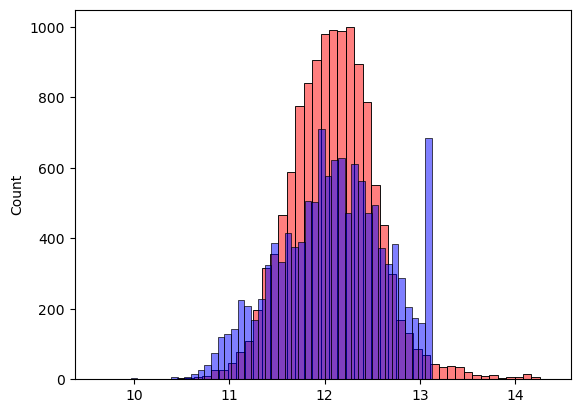

In [126]:
sns.histplot(y_pred1, color="red", alpha=0.5, bins = 50)
sns.histplot(y_train, color="blue", alpha=0.5, bins = 50);

In [127]:
# Evaluation
y_pred1 = w01 + df_val1.values.dot(w1)
round(rmse(y_val, y_pred1), 2)

0.33

#### Option 2

In [128]:
fill_mean = df_train.total_bedrooms.mean()

df_val2 = df_val.copy()
df_test2 = df_test.copy()
df_train2 = df_train.copy()

df_val2.total_bedrooms.fillna(fill_mean, inplace=True)
df_test2.total_bedrooms.fillna(fill_mean, inplace=True)
df_train2.total_bedrooms.fillna(fill_mean, inplace=True)

w02, w2 = train_linear_regression(df_train2.values, y_train)
y_pred2 = w02 + df_train2.values.dot(w2)

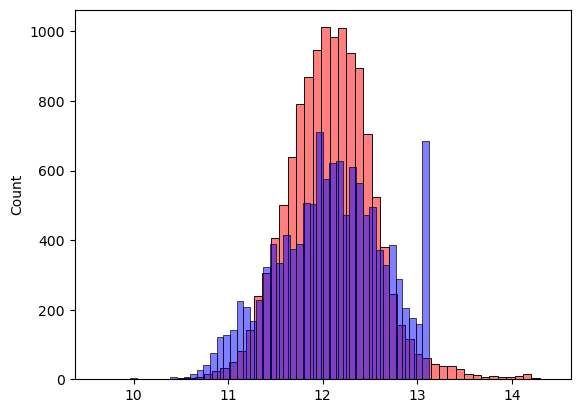

In [129]:
sns.histplot(y_pred2, color="red", alpha=0.5, bins = 50)
sns.histplot(y_train, color="blue", alpha=0.5, bins = 50);

In [130]:
# Evaluation
y_pred2 = w01 + df_val2.values.dot(w1)
round(rmse(y_val, y_pred2), 2)

0.33

### Which option gives better RMSE?
#### They give the same result

## Question 4
1. Now let's train a regularized linear regression.
2. For this question, fill the NAs with 0.
3. Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
4. Use RMSE to evaluate the model on the validation dataset.
5. Round the RMSE scores to 2 decimal digits.

If there are multiple options, select the smallest r.

In [131]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### Which r gives the best RMSE?

In [132]:
rs = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for r in rs:
    w01, w1  = train_linear_regression_reg(df_train1.values, y_train, r=r)
    y_pred1 = w01 + df_val1.values.dot(w1)
    print(r, round(rmse(y_val, y_pred1), 2))

0 0.33
1e-06 0.33
0.0001 0.33
0.001 0.33
0.01 0.33
0.1 0.33
1 0.33
5 0.34
10 0.34


## Question 5
1. We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
2. Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
3. For each seed, do the train/validation/test split with 60%/20%/20% distribution.
4. Fill the missing values with 0 and train a model without regularization.
5. For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
6. What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
7. Round the result to 3 decimal digits (round(std, 3))

In [137]:
rmses = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:  
    np.random.seed(s)
    n = len(df_work)
    nval = int(0.2 * n)
    ntest = int(0.2 * n)
    ntrain = n - (nval + ntest)
    assert (nval+ ntest +ntrain) == n

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df_work.iloc[idx]

    df_train = df_shuffled.iloc[:ntrain]
    df_val = df_shuffled.iloc[ntrain:ntrain+nval]
    df_test = df_shuffled.iloc[ntrain+nval:]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)

    del df_val['median_house_value']
    del df_test['median_house_value']
    del df_train['median_house_value']

    # Training
    df_val1 = df_val.copy()
    df_test1 = df_test.copy()
    df_train1 = df_train.copy()

    df_val1.total_bedrooms.fillna(0, inplace=True)
    df_test1.total_bedrooms.fillna(0, inplace=True)
    df_train1.total_bedrooms.fillna(0, inplace=True)

    w01, w1 = train_linear_regression(df_train1.values, y_train)
    y_pred1 = w01 + df_val1.values.dot(w1)
    rmses.append(round(rmse(y_val, y_pred1),2))


print(round(np.std(rmses), 3))

0.005


## Question 6

1. Split the dataset like previously, use seed 9.
2. Combine train and validation datasets.
3. Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [145]:
np.random.seed(9)
n = len(df_work)
nval = int(0.2 * n)
ntest = int(0.2 * n)
ntrain = n - (nval + ntest)
assert (nval+ ntest +ntrain) == n

idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df_work.iloc[idx]

df_train = df_shuffled.iloc[:ntrain]
df_val = df_shuffled.iloc[ntrain:ntrain+nval]
df_test = df_shuffled.iloc[ntrain+nval:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_val['median_house_value']
del df_test['median_house_value']
del df_train['median_house_value']

# Training
df_val1 = df_val.copy()
df_test1 = df_test.copy()
df_train1 = df_train.copy()

df_val1.total_bedrooms.fillna(0, inplace=True)
df_test1.total_bedrooms.fillna(0, inplace=True)
df_train1.total_bedrooms.fillna(0, inplace=True)

newx = np.concatenate((df_train1, df_val1) , axis=0)
newy = np.concatenate((y_train , y_val), axis=0)

w01, w1  = train_linear_regression_reg(newx, newy, r=0.001)
y_pred1 = w01 + df_test1.values.dot(w1)
print(round(rmse(y_test, y_pred1),2))

0.35
